In [1]:
%matplotlib inline
import os
import cv2
import numpy as np
import random
from matplotlib import pyplot as plt

In [2]:
files = [os.path.join('data', f) for f in os.listdir('data') if f.endswith('.jpg')]

In [3]:
file_index = random.randint(0, len(files)-1)
image = cv2.imread(files[file_index])
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
print(f'File index: {file_index}')

File index: 155


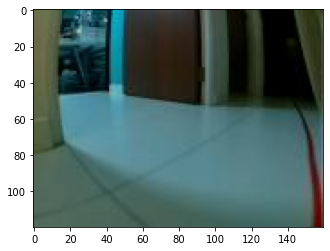

In [4]:
plt.imshow(image)
plt.show()

In [5]:
invert = ~image

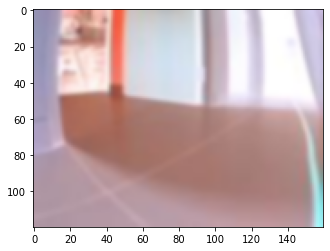

In [6]:
# apply gaussian blur
kernel_size = (5, 5)
gauss_image = cv2.GaussianBlur(invert, kernel_size, 0)

plt.imshow(gauss_image)
plt.show()

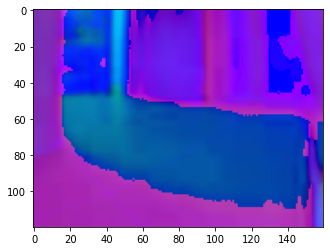

In [7]:
# color transformation to HSV
hsv_image = cv2.cvtColor(gauss_image, cv2.COLOR_RGB2HSV)
plt.imshow(hsv_image)
plt.show()

In [8]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "https://i.stack.imgur.com/gyuw4.png")

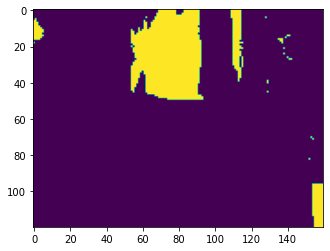

In [9]:
# Since red occurs at both ends, an easier way is to invert the color, and use cyan instead
# Eyeballing puts cyan at around 90 to 110 for the H. Saturation (S) and (V) I just left it
# at almost the full range of 0 to 255.

lower = np.array([90, 0, 20])
upper = np.array([120, 255, 255])

thresh = cv2.inRange(hsv_image, lower, upper)
plt.imshow(thresh)
plt.show()

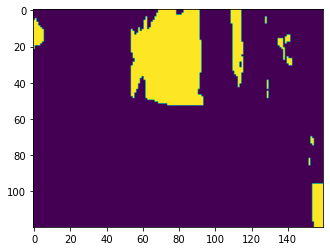

In [10]:
# dilation to join pixels that are close by
rect_kernel = (5, 3)
thresh = cv2.dilate(thresh, rect_kernel, iterations=3)
plt.imshow(thresh)
plt.show()

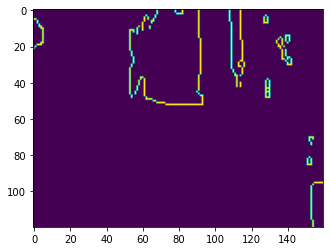

In [11]:
# canny edge edge detection
low_threshold = 100
high_threshold = 400

canny_edges = cv2.Canny(thresh, low_threshold, high_threshold)
plt.imshow(canny_edges)
plt.show()

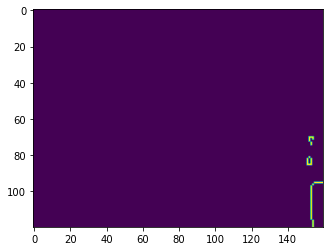

In [12]:
def roi(edges):
    height, width = edges.shape
    mask = np.zeros_like(edges)
    
    # create mask
    polygon = np.array([[
        (0, height * 0.5),
        (width, height * 0.5),
        (width, height),
        (0, height)
    ]], np.int32)
    
    cv2.fillPoly(mask, polygon, 255)
    cropped = cv2.bitwise_and(edges, mask)
    return cropped

roi_image = roi(canny_edges)
plt.imshow(roi_image)
plt.show()

In [13]:
def detect_line_segments(cropped):
    rho = 1 # distance precision in pixels
    angle = np.pi / 180 # angular precision in radians
    min_threshold = 15 # min votes
    line_segments = cv2.HoughLinesP(cropped, rho, angle, min_threshold, np.array([]), 
                                    minLineLength=10, maxLineGap=50)
    return line_segments

In [14]:
line_segments = detect_line_segments(roi_image)
for ls in line_segments:
    print(ls)

[[153 115 153  70]]


In [15]:
def make_points(image, line):
    slope, intercept = line
    y1 = int(image.shape[0]) # bottom of the image
    y2 = int(y1*3/5)         # slightly lower than the middle
    x1 = int((y1 - intercept)/slope)
    x2 = int((y2 - intercept)/slope)
    return [[x1, y1, x2, y2]]


def average_slope_intercept(image, lines):
    left_fit = []
    right_fit = []
    fit = []
    for line in lines:
        x1, y1, x2, y2 = line.reshape(4)
        parameters = np.polyfit((x1, x2), (y1, y2), 1)
        slope = parameters[0]
        if abs(slope) < 0.1:
            continue
        intercept = parameters[1]
        print(slope)
        fit.append((slope, intercept))
                       
    fit_average = np.average(fit, axis=0)
    fit_line = make_points(image, fit_average)

    
    return np.array([fit_line])

In [16]:
averaged_lines = average_slope_intercept(image, line_segments)

0.30228758169934644


/home/benjamintan/miniconda3/envs/homl/lib/python3.7/site-packages/ipykernel_launcher.py:1: RankWarning: Polyfit may be poorly conditioned
  """Entry point for launching an IPython kernel.


In [17]:
def display_lines(image, lines):
    line_image = np.zeros_like(image)
    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line.reshape(4)
            cv2.line(line_image, (x1, y1), (x2, y2), (255, 0, 0), 2)
    return line_image

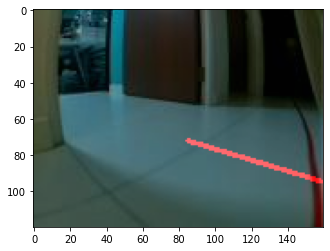

In [18]:
line_image = display_lines(image, averaged_lines)
combo_image = cv2.addWeighted(image, 0.8, line_image, 1, 1)
plt.imshow(combo_image)
plt.show()